# Missing on real World
This notebooks tests the relevance of nodes for the two real world datasets Powergrid and Internet. We iterate over all nodes and remove them and nodes in a radius `r`.
Then we predict the infection center again (without simulation at first) and measure the nodes impact.

In [1]:
import networkx as nx
import rumor_centrality.rumor_detection as raw
import rumor_centrality.jordan_center_alternative as jo
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from rumor_centrality.graph_generator import internet, us_power_grid, scale_free, synthetic_internet
from time import time
from multiprocessing import Pool
from typing import List, Tuple, Dict
from rumor_centrality.graph_simulations import si
from rumor_centrality.graph_visualization import plot_nx_graph
import random

In [2]:
graph_callback = us_power_grid
name = "us_power_grid"
sample_size = 10
percent_radius = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  # Percent of nodes to remove

In [3]:
main_ref_graph = graph_callback().copy(as_view=True)

In [4]:
metric_callback = lambda g: raw.get_center_prediction(
        raw.networkx_graph_to_adj_list(g), use_fact=False
    )

def get_hop_distance(g, center, predicted_center):
    return nx.shortest_path_length(g, center, predicted_center)

In [5]:
def remove_node_and_reconnect(g, node):
    neighbors = g.neighbors(node)
    for i in neighbors:
        for j in neighbors:
            if i != j:
                # Duplicated edges naturally not possible on a graph
                g.add_edge(i, j)
    g.remove_node(node)

In [6]:
def get_experiment_graph(g, percent_missing):
    g = g.copy(as_view=True)
    nodes_to_remove = int(len(g.nodes) * percent_missing)

    _g = g.copy()
    removed_nodes = []
    for _ in range(nodes_to_remove):
        node_to_remove = random.choice(list(_g.nodes))
        remove_node_and_reconnect(_g, node_to_remove)
        removed_nodes.append(node_to_remove)

    return _g, removed_nodes

In [7]:
results = {}

with tqdm(total=len(percent_radius) * sample_size) as bar:
    for p_r in percent_radius:
        results[p_r] = []
        for _ in range(sample_size):
            ex_graph, removed_nodes = get_experiment_graph(main_ref_graph, p_r)            
            predicted_centers = metric_callback(ex_graph)
            
            r = {
                "predicted_centers": predicted_centers,
                "ex_graph": ex_graph,
                "removed_nodes": removed_nodes,
            }
            
            results[p_r].append(r)
            bar.update(1)

100%|█████████████████████████████████████████████████████████████████████| 90/90 [43:27<00:00, 28.97s/it]


In [8]:
import pickle
with open("save_" + name + "_removed_percent.pickle", "wb") as f:
    pickle.dump(results, f)

In [9]:
raise ValueError("STOP")

ValueError: STOP

In [10]:
shortest_paths = nx.shortest_path(main_ref_graph)

In [11]:
def get_best_hop_distance(g, original_centers, predicted_centers):
    best_pair = None
    best_distance = len(g.nodes)
    for o_c in original_centers:
        for p_c in predicted_centers:
            d = len(shortest_paths[o_c][p_c])
            if d < best_distance:
                best_distance = d
                best_pair = (o_c, p_c)
    return best_pair, best_distance

In [12]:
def get_all_hop_distances(g, original_centers, predicted_centers):
    distances = []
    for o_c in original_centers:
        for p_c in predicted_centers:
            distances.append(len(shortest_paths[o_c][p_c]))
    return distances

In [13]:
unaltered_center_prediction = metric_callback(main_ref_graph)

In [14]:
center_results = {}
for k, v in results.items():
    predicted_centers = []
    for _r in v:
        predicted_centers.append(_r["predicted_centers"])
    center_results[k] = predicted_centers

In [15]:
reference_map = []

# Map results to hop distances
hop_distance_freq_by_p_r = {}
for p_r, values in tqdm(center_results.items()):
    hop_distance_freq = {}
    for i, centers in tqdm(enumerate(values)):
        # best_distance = get_hop_distance(g, unaltered_center_prediction[0], centers[20])
        best_pair, best_distance = get_best_hop_distance(main_ref_graph, unaltered_center_prediction, centers)
        hop_distance_freq[best_distance] = hop_distance_freq.get(best_distance, 0) + 1
        
        reference_map.append((p_r, i, best_distance))
        
    hop_distance_freq_by_p_r[p_r] = hop_distance_freq
hop_distance_freq_by_p_r

  0%|                                                                               | 0/9 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.99s/it]
2it [00:06,  3.03s/it]
3it [00:09,  3.18s/it]
4it [00:12,  3.17s/it]
5it [00:15,  3.15s/it]
6it [00:18,  3.12s/it]
7it [00:21,  3.14s/it]
8it [00:25,  3.14s/it]
9it [00:28,  3.15s/it]
10it [00:31,  3.16s/it]
 11%|███████▉                                                               | 1/9 [00:31<04:12, 31.60s/it]
0it [00:00, ?it/s]
1it [00:03,  3.15s/it]
2it [00:06,  3.11s/it]
3it [00:09,  3.11s/it]
4it [00:12,  3.06s/it]
5it [00:15,  3.04s/it]
6it [00:18,  3.04s/it]
7it [00:21,  3.03s/it]
8it [00:24,  3.01s/it]
9it [00:27,  3.00s/it]
10it [00:30,  3.03s/it]
 22%|███████████████▊                                                       | 2/9 [01:01<03:35, 30.83s/it]
0it [00:00, ?it/s]
1it [00:03,  3.08s/it]
2it [00:06,  3.07s/it]
3it [00:09,  3.09s/it]
4it [00:12,  3.06s/it]
5it [00:15,  3.07s/it]
6it [00:18,  3.09s/it]
7it [00:21,  3.08s/it]

{0.01: {1: 10},
 0.05: {1: 10},
 0.1: {1: 10},
 0.2: {1: 10},
 0.3: {1: 10},
 0.4: {1: 10},
 0.5: {1: 10},
 0.6: {1: 10},
 0.7: {1: 10}}

Text(0.5, 0, 'Hop Distance')

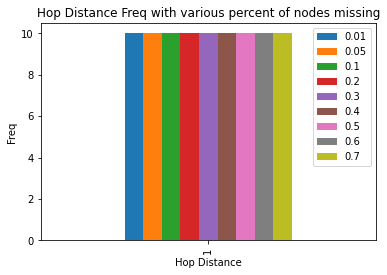

In [16]:
from pandas import DataFrame

df = DataFrame(hop_distance_freq_by_p_r)
df = df.reindex(index=sorted(df.index))
ax = df.plot.bar()
ax.set_title("Hop Distance Freq with various percent of nodes missing")
ax.set_ylabel("Freq")
ax.set_xlabel("Hop Distance")